In [88]:
!pip install pgmpy networkx matplotlib pandas

#Import Libraries

In [89]:
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
from pgmpy.estimators import BayesianEstimator
from pgmpy.sampling import BayesianModelSampling
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools

# -------------------------
# 1) Build the model
# -------------------------

In [90]:
model = DiscreteBayesianNetwork([
    ('C', 'W'), ('T', 'W'),
    ('T', 'I'), ('S', 'I'),
    ('W', 'J'), ('I', 'J')
])

# Root CPDs

In [91]:
c_cpd = TabularCPD(variable='C', variable_card=3,
                   values=[[0.2], [0.5], [0.3]],
                   state_names={'C': ['Low', 'Medium', 'High']})

t_cpd = TabularCPD(variable='T', variable_card=2,
                   values=[[0.4], [0.6]],
                   state_names={'T': ['Weak', 'Strong']})

s_cpd = TabularCPD(variable='S', variable_card=2,
                   values=[[0.5], [0.5]],
                   state_names={'S': ['Weak', 'Strong']})

# Conditional CPDs

In [92]:
written_cpd = TabularCPD(variable='W', variable_card=2,
    values=[[0.8, 0.6, 0.3, 0.4, 0.2, 0.1],  # W=Fail
            [0.2, 0.4, 0.7, 0.6, 0.8, 0.9]], # W=Pass
    evidence=['C', 'T'],
    evidence_card=[3, 2],
    state_names={'W': ['Fail', 'Pass'],
                 'C': ['Low', 'Medium', 'High'],
                 'T': ['Weak', 'Strong']})

interview_cpd = TabularCPD(variable='I', variable_card=2,
    values=[[0.7, 0.4, 0.3, 0.1],  # I=Fail
            [0.3, 0.6, 0.7, 0.9]], # I=Pass
    evidence=['T', 'S'],
    evidence_card=[2, 2],
    state_names={'I': ['Fail', 'Pass'],
                 'T': ['Weak', 'Strong'],
                 'S': ['Weak', 'Strong']})

offer_cpd = TabularCPD(variable='J', variable_card=2,
    values=[[0.99, 0.8, 0.6, 0.1],  # J=No
            [0.01, 0.2, 0.4, 0.9]], # J=Yes
    evidence=['W', 'I'],
    evidence_card=[2, 2],
    state_names={'J': ['No', 'Yes'],
                 'W': ['Fail', 'Pass'],
                 'I': ['Fail', 'Pass']})

# Add CPDs and validate

In [93]:
model.add_cpds(c_cpd, t_cpd, s_cpd, written_cpd, interview_cpd, offer_cpd)
print("Model valid? ", model.check_model())

Model valid?  True



# -------------------------
# 2) Draw DAG
# -------------------------

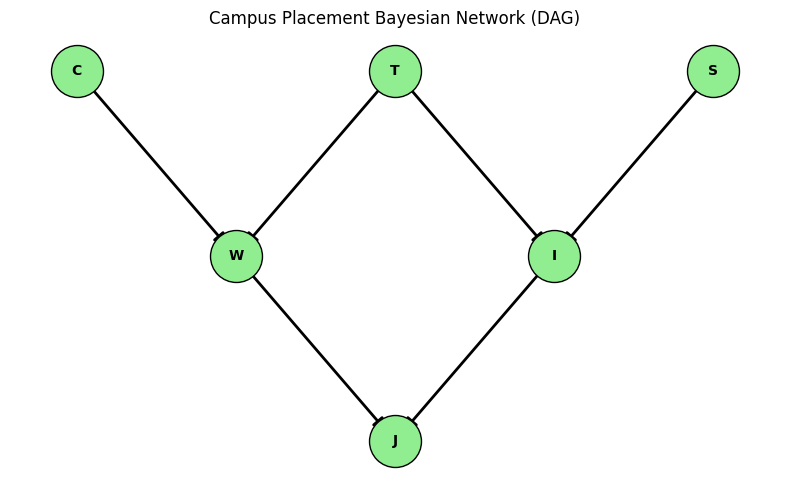

Saved DAG to campus_bn_dag.png


In [94]:
G = nx.DiGraph()
G.add_edges_from(model.edges())
pos = {'C':(-1,1), 'T':(1,1), 'S':(3,1), 'W':(0,0), 'I':(2,0), 'J':(1,-1)}
plt.figure(figsize=(8,5))
nx.draw_networkx_nodes(G, pos, node_size=1400, node_color='lightgreen', edgecolors='black')
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
nx.draw_networkx_edges(G, pos, arrows=True, arrowstyle='-|>', arrowsize=20, width=2)
plt.title("Campus Placement Bayesian Network (DAG)")
plt.axis('off')
plt.tight_layout()
plt.savefig('campus_bn_dag.png')
plt.show()
print("Saved DAG to campus_bn_dag.png")


# -------------------------
# 3) Inference (Variable Elimination)
# -------------------------

In [95]:
infer = VariableElimination(model)

pj = infer.query(variables=['J'])                      # Baseline
pj_hs = infer.query(variables=['J'], evidence={'C':'High','T':'Strong'})  # Predictive
pt_given_j = infer.query(variables=['T'], evidence={'J':'Yes'})           # Diagnostic
pw_given_j = infer.query(variables=['W'], evidence={'J':'Yes'})          # Explaining-away 1
pw_given_j_i = infer.query(variables=['W'], evidence={'J':'Yes','I':'Pass'})  # Explaining-away 2

print("\n--- Inference Results ---")
print("P(J):\n", pj)
print("\nP(J | C=High, T=Strong):\n", pj_hs)
print("\nP(T | J=Yes):\n", pt_given_j)
print("\nP(W | J=Yes):\n", pw_given_j)
print("\nP(W | J=Yes, I=Pass):\n", pw_given_j_i)


--- Inference Results ---
P(J):
 +--------+----------+
| J      |   phi(J) |
+========+==========+
| J(No)  |   0.4823 |
+--------+----------+
| J(Yes) |   0.5177 |
+--------+----------+

P(J | C=High, T=Strong):
 +--------+----------+
| J      |   phi(J) |
+========+==========+
| J(No)  |   0.2638 |
+--------+----------+
| J(Yes) |   0.7362 |
+--------+----------+

P(T | J=Yes):
 +-----------+----------+
| T         |   phi(T) |
+===========+==========+
| T(Weak)   |   0.3316 |
+-----------+----------+
| T(Strong) |   0.6684 |
+-----------+----------+

P(W | J=Yes):
 +---------+----------+
| W       |   phi(W) |
+=========+==========+
| W(Fail) |   0.0930 |
+---------+----------+
| W(Pass) |   0.9070 |
+---------+----------+

P(W | J=Yes, I=Pass):
 +---------+----------+
| W       |   phi(W) |
+=========+==========+
| W(Fail) |   0.1092 |
+---------+----------+
| W(Pass) |   0.8908 |
+---------+----------+



# Extract scalar probabilities for report if needed

In [96]:
def prob_from_factor(factor, var, state):

    idx = factor.state_names[var].index(state)
    return float(factor.values[idx])

pj_yes = prob_from_factor(pj, 'J', 'Yes')
pj_hs_yes = prob_from_factor(pj_hs, 'J', 'Yes')
ptj_strong = prob_from_factor(pt_given_j, 'T', 'Strong')
pwj_pass = prob_from_factor(pw_given_j, 'W', 'Pass')
pwji_pass = prob_from_factor(pw_given_j_i, 'W', 'Pass')

print(f"\nScalar results:")
print(f"P(J=Yes) = {pj_yes:.5f}")
print(f"P(J=Yes | C=High, T=Strong) = {pj_hs_yes:.5f}")
print(f"P(T=Strong | J=Yes) = {ptj_strong:.5f}")
print(f"P(W=Pass | J=Yes) = {pwj_pass:.5f}")
print(f"P(W=Pass | J=Yes, I=Pass) = {pwji_pass:.5f}")



Scalar results:
P(J=Yes) = 0.51765
P(J=Yes | C=High, T=Strong) = 0.73620
P(T=Strong | J=Yes) = 0.66844
P(W=Pass | J=Yes) = 0.90698
P(W=Pass | J=Yes, I=Pass) = 0.89083


# -------------------------
# 4) Sampling 20,000 and learning parameters
# -------------------------

In [97]:
sampler = BayesianModelSampling(model)
print("\nGenerating 20,000 samples ... (this may take a few seconds)")
samples = sampler.forward_sample(size=20000)   # returns array-like
data = pd.DataFrame(samples)
print("Generated samples (first 6 rows):")
display(data.head(6))


Generating 20,000 samples ... (this may take a few seconds)


  0%|          | 0/6 [00:00<?, ?it/s]

Generated samples (first 6 rows):


,C,W,T,I,S,J
0,Medium,Fail,Strong,Pass,Weak,No
1,Medium,Fail,Strong,Pass,Strong,No
2,Low,Fail,Weak,Fail,Strong,No
3,High,Fail,Weak,Fail,Strong,No
4,Medium,Pass,Strong,Pass,Strong,Yes
5,High,Pass,Strong,Pass,Weak,Yes


# Fit a new model with only the structure (learn parameters)

In [98]:
learned_model = DiscreteBayesianNetwork(model.edges())   # same structure
learned_model.fit(data, estimator=BayesianEstimator, prior_type='BDeu', equivalent_sample_size=5)
print("\nParameter learning complete. Learned CPDs available.")


Parameter learning complete. Learned CPDs available.



# Get learned CPD for J

In [99]:
learned_offer = learned_model.get_cpds('J')
print("\nLearned CPD for J (P(J | W, I)):")
print(learned_offer)


Learned CPD for J (P(J | W, I)):
+--------+----------------------+-----+---------------------+
| I      | I(Fail)              | ... | I(Pass)             |
+--------+----------------------+-----+---------------------+
| W      | W(Fail)              | ... | W(Pass)             |
+--------+----------------------+-----+---------------------+
| J(No)  | 0.9913603518693057   | ... | 0.09942725227199672 |
+--------+----------------------+-----+---------------------+
| J(Yes) | 0.008639648130694313 | ... | 0.9005727477280032  |
+--------+----------------------+-----+---------------------+


# -------------------------
# 5) Compare original vs learned CPD for P(J | W, I)
# -------------------------

In [100]:
orig = model.get_cpds('J')            # original
# NOTE: orig.values may be multi-dimensional (shape: var_card x card_e1 x card_e2 ...)
orig_vals = orig.values.reshape(orig.values.shape[0], -1)
learn_vals = learned_offer.values.reshape(learned_offer.values.shape[0], -1)


# Build column labels in the same evidence order used in the CPD (evidence = ['W','I'])

In [101]:

# Safely extract evidence order
evidence_order = orig.get_evidence()  # replaces orig.evidence
evidence_states = [orig.state_names[e] for e in evidence_order]

# Create readable column labels
column_labels = [
    ", ".join(f"{e}={v}" for e, v in zip(evidence_order, combo))
    for combo in itertools.product(*evidence_states)
]

# Flatten 3D arrays into 2D
orig_vals = orig.values.reshape(2, -1)
learn_vals = learned_offer.values.reshape(2, -1)

# Build DataFrames
orig_df = pd.DataFrame(orig_vals, index=[f"J={s}" for s in orig.state_names['J']], columns=column_labels)
learn_df = pd.DataFrame(learn_vals, index=[f"J={s}" for s in learned_offer.state_names['J']], columns=column_labels)

print("\nOriginal P(J | W,I):")
display(orig_df)
print("\nLearned P(J | W,I):")
display(learn_df)


Original P(J | W,I):


,"I=Fail, W=Fail","I=Fail, W=Pass","I=Pass, W=Fail","I=Pass, W=Pass"
J=No,0.99,0.8,0.6,0.1
J=Yes,0.01,0.2,0.4,0.9



Learned P(J | W,I):


,"I=Fail, W=Fail","I=Fail, W=Pass","I=Pass, W=Fail","I=Pass, W=Pass"
J=No,0.99136,0.592121,0.805462,0.099427
J=Yes,0.00864,0.407879,0.194538,0.900573


# Save CSVs

In [102]:
orig_df.to_csv('original_PJ_W_I.csv')
learn_df.to_csv('learned_PJ_W_I.csv')
print("Saved original_PJ_W_I.csv and learned_PJ_W_I.csv")

Saved original_PJ_W_I.csv and learned_PJ_W_I.csv



# Quick numeric diff

In [103]:
diff = np.abs(orig_vals - learn_vals)
print("\nAbsolute difference matrix (orig - learned):")
display(pd.DataFrame(diff, index=[f"J={s}" for s in orig.state_names['J']], columns=column_labels))
print("Max absolute difference:", diff.max())


Absolute difference matrix (orig - learned):


,"I=Fail, W=Fail","I=Fail, W=Pass","I=Pass, W=Fail","I=Pass, W=Pass"
J=No,0.00136,0.207879,0.205462,0.000573
J=Yes,0.00136,0.207879,0.205462,0.000573


Max absolute difference: 0.20787906290770897


###  6) Analysis
The probability P(W=Pass | J=Yes) = 0.9070 decreases slightly to
P(W=Pass | J=Yes, I=Pass) = 0.8908 when we add evidence that the interview was passed.
This shows the *explaining away effect*: since either W or I can explain J=Yes,
learning that I=Pass already accounts for J, reducing the need to attribute it to W=Pass.
